In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import os

In [3]:
import h5py
import cPickle as pickle

In [4]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

In [5]:
from uncertainties import ufloat, unumpy

In [6]:
def get_bin_sizes(bin_edges):
    return np.abs(np.diff(bin_edges))

In [7]:
LEVEL = 7
NAME = '14585'
INFILE = NAME+'.pkl'
WEIGHT_FILE = NAME+'_weights.hdf5'
DATA_NU = '/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NuVec.dat'
DATA_NUBAR= '/data/icecube/data/NuTeV/nutev_data/data/nutevpack/NubarVec.dat'
Y_BINNING = np.array([0, 0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.97, 1.0])
X_BINNING = np.array([0.0001, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
E_BINNING = np.array([30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 230, 260, 290, 320, 360])
Y_CENTERS = np.array([0.0005, 0.026, 0.075, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.935, 0.985])
X_CENTERS = np.array([0.015, 0.045, 0.08, 0.125, 0.175, 0.225, 0.275, 0.35, 0.45, 0.55, 0.65, 0.75])
E_CENTERS = np.array([35, 45, 55, 65, 75, 85, 95, 110, 130, 150, 170, 190, 215, 245, 275, 305, 340])
N_TARGET = 56
WA_NU = 0.677E-38# * N_TARGET
WA_NUBAR = 0.334E-38# * N_TARGET
print(WA_NU, WA_NUBAR)

6.77e-39 3.34e-39


In [8]:
infile = '/data/icecube/data/mlarson/level7_24Nov2015/GENIE_parms/level'+str(LEVEL)+'/'+INFILE
inweights = '/data/icecube/data/mlarson/level7_24Nov2015/GENIE_parms/level'+str(LEVEL)+'/'+WEIGHT_FILE
input_file = pickle.load(open(infile, 'rb'))
if '16' in NAME:
    weights_raw = np.ones(len(input_file['cc']))
else:
    weights_raw = np.array(h5py.File(inweights, 'r')['weights'][:])

In [9]:
if not np.sum(weights_raw) == len(input_file['cc']):
    weights_raw *= 3600 * 24 * 365.
    if LEVEL == 0:
        weights_raw /= 3.
    elif LEVEL == 7:
        if '12585' in INFILE:
            weights_raw /= 275.
        elif '14585' in INFILE:
            weights_raw /= 245.
else:
    print(weights_raw)

In [10]:
print(sorted(input_file.keys()))
print(weights_raw.shape)
x_array = input_file['x']
invalid_entries = x_array < 0
x_array = x_array[~invalid_entries]
energy_array = input_file['Ev'][~invalid_entries]
y_array = input_file['y'][~invalid_entries]
pdg_array = input_file['neu'][~invalid_entries]
dis_array = input_file['dis'][~invalid_entries]
nu_mask = pdg_array > 0
nubar_mask = pdg_array < 0
print(r'{0} invalid entries'.format(np.sum(invalid_entries)))

['A', 'Ef', 'Ei', 'El', 'En', 'Ev', 'KEf', 'KEl', 'Q2', 'Q2s', 'W', 'Ws', 'Z', '_azimax', '_azimin', '_elogmax', '_elogmin', '_glbprbscale', '_gvold', '_gvoll', '_gvolr', '_ngennu', '_plawind', '_zenmax', '_zenmin', 'calresp0', 'cc', 'charm', 'coh', 'dfr', 'diffxsec', 'dis', 'em', 'energy', 'hitnuc', 'hitqrk', 'iev', 'imd', 'nc', 'neu', 'neut_code', 'nf', 'nfem', 'nfk0', 'nfkm', 'nfkp', 'nfn', 'nfother', 'nfp', 'nfpi0', 'nfpim', 'nfpip', 'ni', 'niem', 'nik0', 'nikm', 'nikp', 'nin', 'niother', 'nip', 'nipi0', 'nipim', 'nipip', 'nuance_code', 'nuel', 'pdgf', 'pdgi', 'pdgl', 'prob', 'pxf', 'pxi', 'pxl', 'pxn', 'pxv', 'pyf', 'pyi', 'pyl', 'pyn', 'pyv', 'pzf', 'pzi', 'pzl', 'pzn', 'pzv', 'qel', 'res', 'resc', 'resid', 'rw_AhtBY', 'rw_BhtBY', 'rw_CV1uBY', 'rw_CV2uBY', 'rw_MaCCQE', 'rw_MaCCRES', 'rw_MaCOHpi', 'rw_MaNCEL', 'rw_MaNCRES', 'sea', 't', 'tgt', 'tgtmass', 'ts', 'vtxt', 'vtxx', 'vtxy', 'vtxz', 'wght', 'x', 'xs', 'xsec', 'y', 'ys']
(509542,)
4154 invalid entries


In [55]:
a = 0.08
b = 0.8670889394981961
weights = weights_raw[~invalid_entries] * np.power(x_array, -a) * b
print(weights.shape)

(505388,)


In [14]:
with open(DATA_NU, 'r') as f:
    table_nu = np.genfromtxt(f, usecols=range(9), skip_header=1)
with open(DATA_NUBAR, 'r') as f:
    table_nubar = np.genfromtxt(f, usecols=range(9), skip_header=1)

In [15]:
def decode_index(index):
    ybin = index % 100 - 1
    xbin = ((index % 10000) - ybin) / 100 - 1 - 1
    ebin = ((index % 1000000) - xbin*100 -ybin)/10000 - 1 - 1

    return [map(int, (ebin, xbin, ybin))]

nu_decoded_index, nubar_decoded_index = [], []
for index in table_nu[:,0]:
    nu_decoded_index.append(decode_index(index))
for index in table_nubar[:,0]:
    nubar_decoded_index.append(decode_index(index))
nu_decoded_index = np.vstack(nu_decoded_index)
nubar_decoded_index = np.vstack(nubar_decoded_index)
print(nu_decoded_index)

[[ 0  1  5]
 [ 0  1  6]
 [ 0  1  7]
 ..., 
 [16 11  2]
 [16 11  3]
 [16 11  4]]


In [16]:
nu_sys = table_nu[:,3:].T
nubar_sys = table_nubar[:,3:].T
print(nu_sys.shape)
nu_sys_err_2 = nu_sys[0]**2 + nu_sys[1]**2 + nu_sys[2]**2 + nu_sys[3]**2 + nu_sys[4]**2 + nu_sys[5]**2
nubar_sys_err_2 = nubar_sys[0]**2 + nubar_sys[1]**2 + nubar_sys[2]**2 + nubar_sys[3]**2 + nubar_sys[4]**2 + nubar_sys[5]**2
nu_xsec_array = unumpy.uarray(table_nu[:,1], np.sqrt(table_nu[:,2]**2 + nu_sys_err_2))
nubar_xsec_array = unumpy.uarray(table_nubar[:,1], np.sqrt(table_nubar[:,2]**2 + nubar_sys_err_2))

(6, 1423)


In [17]:
nu_data_matrix = np.zeros(map(len, (E_CENTERS, X_CENTERS, Y_CENTERS)))
nubar_data_matrix = np.zeros(map(len, (E_CENTERS, X_CENTERS, Y_CENTERS)))
nu_data_matrix, nubar_data_matrix = unumpy.uarray(nu_data_matrix, nu_data_matrix), \
                                    unumpy.uarray(nubar_data_matrix, nubar_data_matrix)
print(nu_data_matrix.shape)
for idx, entry in enumerate(nu_decoded_index):
    nu_data_matrix[tuple(entry)] = nu_xsec_array[idx]
for idx, entry in enumerate(nubar_decoded_index):
    nubar_data_matrix[tuple(entry)] = nubar_xsec_array[idx]
nu_data_matrix, nubar_data_matrix = ma.masked_equal(nu_data_matrix, 0), ma.masked_equal(nubar_data_matrix, 0)

(17, 12, 13)


In [18]:
def make_histo(array, weights):
    hist, edges = np.histogram(array, bins=Y_BINNING, weights=weights)
    hist_2, edges = np.histogram(array, bins=Y_BINNING, weights=weights**2)

    u_hist = unumpy.uarray(hist, np.sqrt(hist_2))
    return ma.masked_equal(u_hist, 0)

In [19]:
e_bin_sizes = get_bin_sizes(E_BINNING).astype(float)
x_bin_sizes = get_bin_sizes(X_BINNING).astype(float)
y_bin_sizes = get_bin_sizes(Y_BINNING).astype(float)

NU_HISTOGRAMS = unumpy.uarray(np.zeros(map(len, (e_bin_sizes, x_bin_sizes, y_bin_sizes))).astype(float),
                              np.zeros(map(len, (e_bin_sizes, x_bin_sizes, y_bin_sizes))).astype(float))
NUBAR_HISTOGRAMS = unumpy.uarray(np.zeros(map(len, (e_bin_sizes, x_bin_sizes, y_bin_sizes))).astype(float),
                                 np.zeros(map(len, (e_bin_sizes, x_bin_sizes, y_bin_sizes))).astype(float))
SCALING_NU, SCALING_NUBAR = [], []
for e_idx, e_bin in enumerate(E_BINNING[:-1]):
    energy_mask = (energy_array >= e_bin) & (energy_array < E_BINNING[e_idx + 1])
    weights_e = weights[energy_mask]
    y_array_e = y_array[energy_mask]
    x_array_e = x_array[energy_mask]
    nu_mask_e = nu_mask[energy_mask]
    nubar_mask_e = nubar_mask[energy_mask]
    
    sigma_nu = sigma_nubar = 0
    NU_HISTOGRAMS[e_idx], NUBAR_HISTOGRAMS[e_idx] = {}, {}
    for x_idx, x_bin in enumerate(X_BINNING[:-1]):
        x_mask = (x_array_e >= x_bin) & (x_array_e < X_BINNING[x_idx+1])
        y_array_e_x = y_array_e[x_mask]
        weights_e_x = weights_e[x_mask]
        nu_mask_e_x = nu_mask_e[x_mask]
        nubar_mask_e_x = nubar_mask_e[x_mask]

        sigma_nu_x_nw = make_histo(
            y_array_e_x[nu_mask_e_x], np.ones(weights_e_x[nu_mask_e_x].shape)
        )
        sigma_nu_x = make_histo(
            y_array_e_x[nu_mask_e_x], weights_e_x[nu_mask_e_x]
        )
        sigma_nu_x_e_nw = sigma_nu_x_nw * (1 / E_CENTERS[e_idx].astype(float))
        sigma_nu_x_e = sigma_nu_x * (1 / E_CENTERS[e_idx].astype(float))
        
        sigma_nubar_x_nw = make_histo(
            y_array_e_x[nubar_mask_e_x], np.ones(weights_e_x[nubar_mask_e_x].shape)
        )
        sigma_nubar_x = make_histo(
            y_array_e_x[nubar_mask_e_x], weights_e_x[nubar_mask_e_x]
        )
        sigma_nubar_x_e_nw = sigma_nubar_x_nw * (1 / E_CENTERS[e_idx].astype(float))
        sigma_nubar_x_e = sigma_nubar_x * (1 / E_CENTERS[e_idx].astype(float))
        
        factors = 1 / (y_bin_sizes * x_bin_sizes[x_idx])
        NU_HISTOGRAMS[e_idx][x_idx] = sigma_nu_x_e * factors
        NUBAR_HISTOGRAMS[e_idx][x_idx] = sigma_nubar_x_e * factors
        sigma_nu += np.sum(unumpy.nominal_values(sigma_nu_x_e_nw.data))# * factors)
        sigma_nubar += np.sum(unumpy.nominal_values(sigma_nubar_x_e_nw.data))# * factors)

    SCALING_NU.append((WA_NU / 1E-38) / sigma_nu)
    SCALING_NUBAR.append((WA_NUBAR / 1E-38) / sigma_nubar)
SCALING_NU, SCALING_NUBAR = map(ma.masked_invalid, (SCALING_NU, SCALING_NUBAR))
NU_HISTOGRAMS = ma.masked_equal(NU_HISTOGRAMS, 0)
NUBAR_HISTOGRAMS = ma.masked_equal(NUBAR_HISTOGRAMS, 0)
print(SCALING_NU)
print(SCALING_NUBAR)

[0.0030828779599271403 0.0065955834596232955 0.012216207349081364
 0.020325635103926095 0.03013353115727003 0.02915146909827761
 0.0374359720605355 0.029943707277844796 0.04734265734265735
 0.07555803571428571 0.10796435272045027 0.15497590361445782
 0.14732287449392714 0.213194087403599 0.28165658093797274
 0.4009417475728156 0.42157509157509165]
[0.003709933354490639 0.007755417956656347 0.014218266253869972
 0.02414905450500557 0.03498603351955307 0.03215175537938845
 0.04382596685082872 0.033613906678865504 0.054547738693467344
 0.08667820069204152 0.1299313501144165 0.15630541871921183
 0.1628344671201814 0.26060509554140127 0.35057251908396947
 0.48279620853080574 0.48948275862068985]


In [20]:
def format_axis(ax, binning, x_label=r'', title=r'', lhs=False, ylim=None):
    ax.set_title(title)

    ax.set_xlim(np.min(binning), np.max(binning))
    for xmaj in binning:
        ax.axvline(x=xmaj, ls=':', color='gray', alpha=0.4, linewidth=1)
    if x_label == r'':
        ax.get_xaxis().set_ticks([])
    else:
        ax.set_xlabel(x_label, fontsize=14)

    ax.tick_params(axis='y', labelsize=10)
    if not ylim is None:
        ax.set_ylim(ylim)
    #ax.set_ylim(1, 7000)
    #ax.set_yscale('log')
    for ymaj in ax.yaxis.get_majorticklocs():
        ax.axhline(y=ymaj, ls=':', color='gray', alpha=0.4, linewidth=1)
    if not lhs:
        ax.get_yaxis().set_ticks([])
        xticks = ax.xaxis.get_major_ticks()
        try:
            xticks[0].set_visible(False)
        except:
            pass
    else: 
        yticks = ax.yaxis.get_major_ticks()
        for yt in yticks:
            yt.label.set_fontsize(9)
        yticks[0].set_visible(False)


def plot_histo(ax, binning, centers, histo, colour):
    histo_0 = np.concatenate(([histo[0]], histo))
    ax.step(
        binning, unumpy.nominal_values(histo_0),
        alpha=0.5, color=colour, drawstyle='steps-pre', linewidth=2, linestyle=':'
    )
    ax.errorbar(
        centers, unumpy.nominal_values(histo),
        xerr=0, yerr=unumpy.std_devs(histo),
        capsize=0.7, alpha=1, color=colour, linestyle='None', markersize=0.5, linewidth=1
    )

    
def plot_data(ax, centers, array, colour):
    ax.errorbar(
        centers, unumpy.nominal_values(array), xerr=0, yerr=unumpy.std_devs(array),
        capsize=1.5, alpha=1, color=colour, linestyle='-', markersize=3, linewidth=0.4
    )

WA nu/nubar 6.77e-39 3.34e-39
E: 9, 150


/data/mandalia/programs/anaconda2/envs/pisa/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/.data/mandalia/programs/anaconda2/envs/pisa/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/.data/mandalia/programs/anaconda2/envs/pisa/lib/python2.7/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


nu/nubar integral = 2.84217417736e-38 1.31193502364e-38


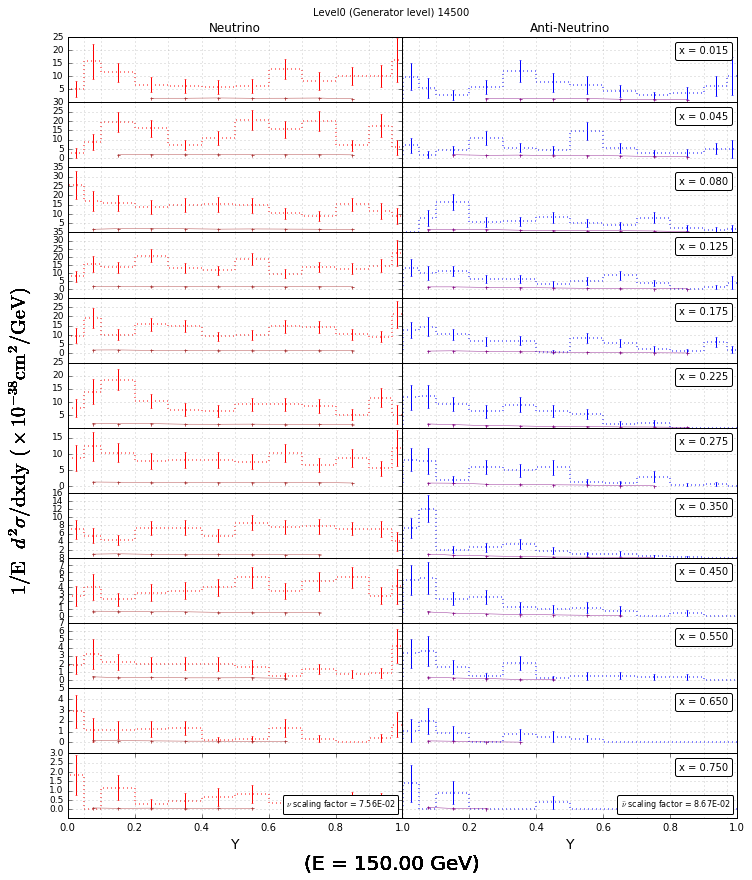

In [21]:
#E_PLOT = None
#E_PLOT = [65, 150, 245]
E_PLOT = [150]

x_bin_sizes = get_bin_sizes(X_BINNING).astype(float)
y_bin_sizes = get_bin_sizes(Y_BINNING).astype(float)
print('WA nu/nubar {0} {1}'.format(WA_NU, WA_NUBAR))
for e_idx, e_bin in enumerate(E_BINNING[:-1]):
    e_cont = True
    if E_PLOT is None:
        e_cont = False
    else:
        for x in E_PLOT:
            if x >= e_bin and x < E_BINNING[e_idx + 1]:
                e_cont = False
    if e_cont:
        continue
    print(r'E: {0}, {1}'.format(e_idx, E_CENTERS[e_idx]))

    fig = plt.figure(figsize=[12, 14])
    if LEVEL == 0:
        fig.suptitle('Level0 (Generator level) '+NAME, y=0.93)
    elif LEVEL == 7:
        fig.suptitle('Level7 (Final level) '+NAME, y=0.93)
    gs = gridspec.GridSpec(len(X_CENTERS), 1)
    gs.update(hspace=0., wspace=0.)

    nu_int = 0
    nubar_int = 0
    for x_idx, x_bin in enumerate(X_BINNING[:-1]):
        gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[x_idx],
                                               wspace=0, hspace=0, width_ratios=[1,1])

        ax0 = fig.add_subplot(gs0[0])

        plot_histo(ax0, Y_BINNING, Y_CENTERS, NU_HISTOGRAMS[e_idx][x_idx] * SCALING_NU[e_idx], colour='red')
        plot_data(ax0, Y_CENTERS, nu_data_matrix[e_idx][x_idx], colour='brown')
            
        ax1 = fig.add_subplot(gs0[1])
        plot_histo(ax1, Y_BINNING, Y_CENTERS, NUBAR_HISTOGRAMS[e_idx][x_idx] * SCALING_NUBAR[e_idx], colour='blue')
        plot_data(ax1, Y_CENTERS, nubar_data_matrix[e_idx][x_idx], colour='purple')

        nu_int += np.sum(NU_HISTOGRAMS[e_idx][x_idx].data * y_bin_sizes) * SCALING_NU[e_idx] * x_bin_sizes[x_bin]
        nubar_int += np.sum(NUBAR_HISTOGRAMS[e_idx][x_idx].data * y_bin_sizes) * SCALING_NUBAR[e_idx] * x_bin_sizes[x_bin]

        ylim = (np.min([ax0.get_ylim()[0], ax1.get_ylim()[0]]),
                np.max([ax0.get_ylim()[1], ax1.get_ylim()[1]]))
        #ylim = (0, 10)
        ax0.set_ylim(ylim)
        ax1.set_ylim(ylim)
        #ax1.set_ylim(ax0.get_ylim())
        if x_idx == 0:
            format_axis(ax0, Y_BINNING, title=r'Neutrino', lhs=True)
            format_axis(ax1, Y_BINNING, title=r'Anti-Neutrino')
        elif x_idx == len(X_CENTERS)-1:
            format_axis(ax0, Y_BINNING, x_label=r'Y', lhs=True)
            format_axis(ax1, Y_BINNING, x_label=r'Y')
            
            at0 = AnchoredText(r'$\nu$ scaling factor = {0:.2E}'.format(SCALING_NU[e_idx]),
                               prop=dict(size=8), frameon=True, loc=4)
            at0.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax0.add_artist(at0)
            
            at1 = AnchoredText(r'$\bar\nu$ scaling factor = {0:.2E}'.format(SCALING_NUBAR[e_idx]),
                               prop=dict(size=8), frameon=True, loc=4)
            at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax1.add_artist(at1)
        else:
            format_axis(ax0, Y_BINNING, lhs=True)
            format_axis(ax1, Y_BINNING)
        
        at = AnchoredText(r'x = {0:.3f}'.format(X_CENTERS[x_idx]),
                          prop=dict(size=10), frameon=True, loc=1)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax1.add_artist(at)
        
        fig.text(0.055, 0.5, r'$\rm{1/E}$  $d^2\sigma/\rm{dx dy}$ $(\times 10^{-38}\rm{cm}^2/\rm{GeV})$',
                 rotation='vertical', va='center', size=20)
        fig.text(0.5, 0.075, r'(E = {0:.2f} GeV)'.format(E_CENTERS[e_idx]), ha='center', size=20)
    
    print('nu/nubar integral = {0} {1}'.format(nu_int.n * 1E-38, nubar_int.n * 1E-38))
    #fig.savefig('./images/NuTeV/gevgen_teppei/y/'+NAME+'_'+'{0:06.2f}.png'.format(E_CENTERS[e_idx]), bbox_inches='tight')

In [65]:
def make_plot(energy_nw, energy_w, binning, outname):
    fig = plt.figure(figsize=[10, 7])
    if LEVEL == 0:
        fig.suptitle('Level0 (Generator level) '+NAME, y=1.005)
    elif LEVEL == 7:
        fig.suptitle('Level7 (Final level) '+NAME, y=1.005)
        
    gs = gridspec.GridSpec(2, 1)
    gs.update(hspace=0., wspace=0.)
    
    ax0 = fig.add_subplot(gs[0])
    ax0.set_xlim(np.min(binning), np.max(binning))
    ax0.set_ylim([1, 1E6])
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    for xmaj in ax0.xaxis.get_majorticklocs():
        ax0.axvline(x=xmaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    for ymaj in ax0.yaxis.get_majorticklocs():
        ax0.axhline(y=ymaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    ax0.get_xaxis().set_ticks([])
    ax0.set_ylabel('N (DIS)', size=18)
    yticks = ax0.yaxis.get_major_ticks()
    yticks[0].set_visible(False)
    yticks[1].set_visible(False)
    
    energy_nw_0 = np.concatenate(([energy_nw[0]], energy_nw))
    energy_w_0 = np.concatenate(([energy_w[0]], energy_w))
    ax0.step(
        binning, energy_nw_0, alpha=1, color='black', drawstyle='steps-mid', label='original', linewidth=1.2, linestyle='-'
    )
    ax0.step(
        binning, energy_w_0, alpha=1, color='red', drawstyle='steps-mid', label=r'$b x^{-a}$ weight', linewidth=1.2, linestyle='-'
    )
    ax0.legend()
    
    at = AnchoredText(r'$a$ = {0};  $b$ = {1}'.format(a, b),
                      prop=dict(size=10), frameon=True, loc=2)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax0.add_artist(at)
    
    ax1 = fig.add_subplot(gs[1])
    ax1.set_xlim(np.min(binning), np.max(binning))
    ax1.set_xlabel(r'Energy (GeV)', size=18)
    ax1.set_ylabel('ratio', size=18)
    ax1.set_ylim([0.8, 1.2])
    ax1.set_xscale('log')
    for xmaj in ax1.xaxis.get_majorticklocs():
        ax1.axvline(x=xmaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    for ymaj in ax1.yaxis.get_majorticklocs():
        ax1.axhline(y=ymaj, ls=':', color='gray', alpha=0.7, linewidth=1)
        
    ratio = energy_w / energy_nw
    ratio_0 = np.concatenate(([ratio[0]], ratio))
    ax1.step(
        binning, ratio_0, alpha=1, color='red', drawstyle='steps-mid', linewidth=1.2, linestyle='-'
    )
    ax1.step(
        binning, np.ones(len(ratio_0)), alpha=1, color='black', drawstyle='steps-mid', linewidth=1.2, linestyle='-'
    )

    fig.tight_layout()
    # fig.savefig('./test.pdf', bbox_inches='tight')
    fig.savefig('./images/NuTeV/L7/'+outname, bbox_inches='tight')

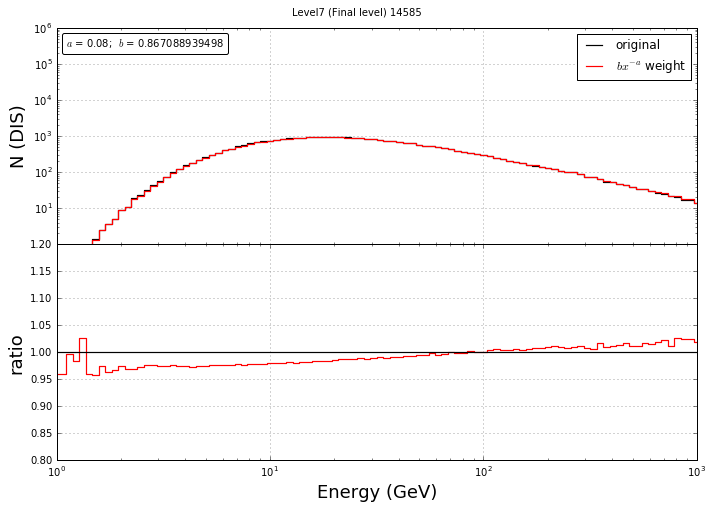

In [66]:
binning = np.logspace(0, 3, 100)
e_hist, edges = np.histogram(energy_array[dis_array], bins=binning, weights=weights_raw[~invalid_entries][dis_array])
e_hist_w, edges = np.histogram(energy_array[dis_array], bins=binning, weights=weights[dis_array])

make_plot(e_hist, e_hist_w, binning, 'energy_shift_dis.png')